In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
batch_size = 128
num_epochs = 100
seed = 1
out_dir = './output'

In [3]:
device = None
torch.manual_seed(seed)
if torch.cuda.is_available():
    print('cuda is available!')
    dev_id = 3
    device = torch.device('cuda:'+str(dev_id))
    torch.cuda.manual_seed(seed)
else:
    device = torch.device('cpu')

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

cuda is available!


Download MNIST dataset

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=False,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

Processing...
Done!


## VAE module

In [5]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 2)  # mu
        self.fc22 = nn.Linear(512, 2)  # logvar

        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))
    
    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
model = VAE()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Loss function

In [7]:
def loss_function(recon_x, x, mu, logvar):
    # reconstruction loss
    recon = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    # KL divergence (normal distribution)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon + kld

## Training

In [9]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    # loss_function()
    train_loss /= len(train_loader.dataset)

    return train_loss    
    

def test(epoch):
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        with torch.no_grad():
            data = data.to(device)
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.item()
        
        if epoch % 10 == 0:
            if batch_idx == 0:
                n = 8
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.data.cpu(),
                           '{}/reconstruction_{}.png'.format(out_dir, epoch), nrow=n)

    test_loss /= len(test_loader.dataset)

    return test_loss

loss_list = []
test_loss_list = []
for epoch in range(1, num_epochs + 1):
    loss = train(epoch)
    test_loss = test(epoch)

    print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss,
        test_loss))

    # logging
    loss_list.append(loss)
    test_loss_list.append(test_loss)

# save the training model
np.save(f'{out_dir}/loss_list.npy', np.array(loss_list))
np.save(f'{out_dir}/test_loss_list.npy', np.array(test_loss_list))
torch.save(model.state_dict(), f'{out_dir}/vae.pth')

/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [2/100], loss: 185.8968 test_loss: 167.4400
epoch [3/100], loss: 165.7026 test_loss: 162.8053
epoch [4/100], loss: 162.3713 test_loss: 160.0275
epoch [5/100], loss: 160.2616 test_loss: 158.4091
epoch [6/100], loss: 158.6830 test_loss: 157.2503
epoch [7/100], loss: 157.4129 test_loss: 156.1155
epoch [8/100], loss: 156.3945 test_loss: 155.2886
epoch [9/100], loss: 155.5870 test_loss: 154.7436
epoch [10/100], loss: 154.8997 test_loss: 154.5068
epoch [11/100], loss: 154.2119 test_loss: 153.7692
epoch [12/100], loss: 153.6262 test_loss: 153.3293
epoch [13/100], loss: 153.1592 test_loss: 153.4993
epoch [14/100], loss: 152.7298 test_loss: 152.7136
epoch [15/100], loss: 152.2371 test_loss: 152.3074
epoch [16/100], loss: 151.8910 test_loss: 152.3166
epoch [17/100], loss: 151.5400 test_loss: 151.6037
epoch [18/100], loss: 151.1602 test_loss: 151.6299
epoch [19/100], loss: 150.8326 test_loss: 151.2959
epoch [20/100], loss: 150.4522 test_loss: 151.0092
epoch [21/100], loss: 150.1494 test_los

Plotting the loss curve:

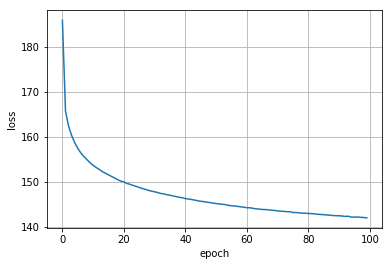

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_list = np.load('{}/loss_list.npy'.format(out_dir))
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

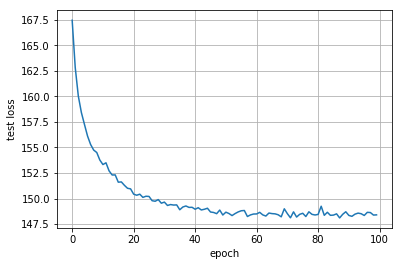

In [12]:
test_loss_list = np.load('{}/test_loss_list.npy'.format(out_dir))
plt.plot(test_loss_list)
plt.xlabel('epoch')
plt.ylabel('test loss')
plt.grid()


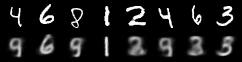

In [13]:
from IPython.display import Image
Image('output/reconstruction_10.png')

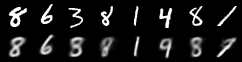

In [14]:
Image('output/reconstruction_100.png')

In [22]:
model.load_state_dict(torch.load('{}/vae.pth'.format(out_dir),
                                 map_location=lambda storage,
                                 loc: storage))
test_dataset = datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
images, labels = iter(test_loader).next()
images = images.view(10000, -1)

z = model.encode(images.to(device))
mu, logvar = z
mu, logvar = mu.cpu(), logvar.cpu()
mu, logvar = mu.data.numpy(), logvar.data.numpy()
print(mu.shape, logvar.shape)

(10000, 2) (10000, 2)


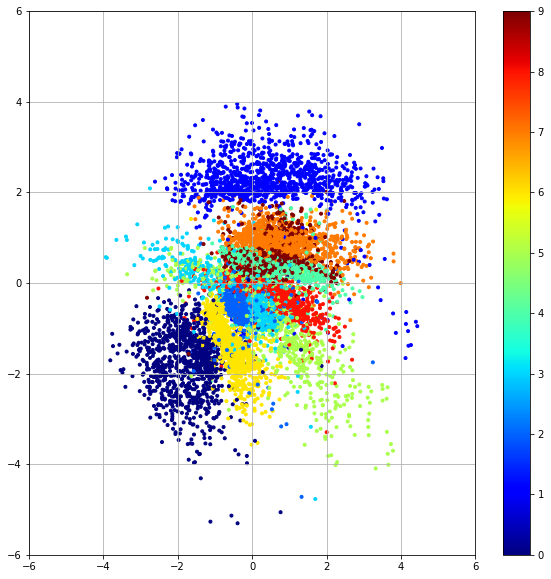

In [23]:
import pylab
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.xlim((-6, 6))
plt.ylim((-6, 6))
plt.grid()